### Import necessaries libraries

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2 as cv
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.math import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/emotion_train'

### Visualize data

In [4]:
def visualize_data(data_path):
    plt.figure(figsize=(15,10))
    for i in range(1,17):
        plt.subplot(4,4,i)
        rand_image = plt.imread(data_path+'/'+random.choice(os.listdir(data_path)))
        plt.imshow(rand_image)
        plt.yticks([])
        plt.xticks([])
    print(f'image shape is {rand_image.shape[0]}*{rand_image.shape[1]} pixles')

image shape is 48*48 pixles


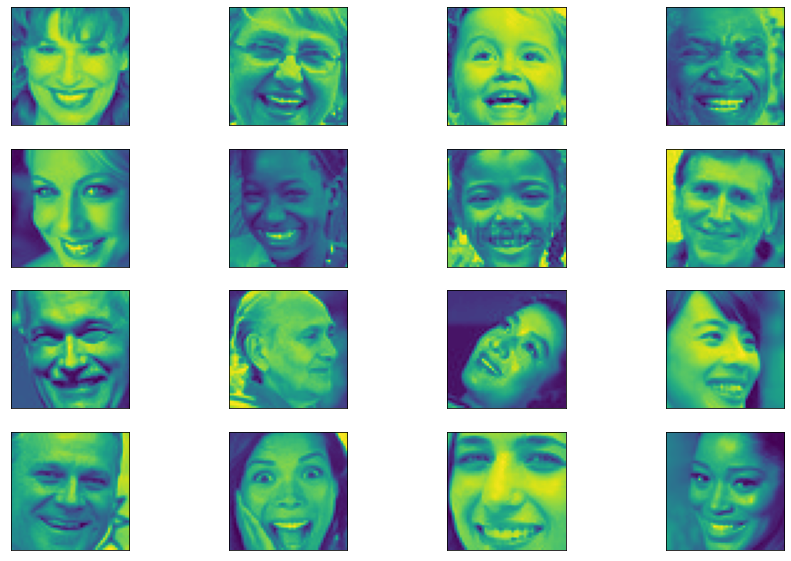

In [5]:
visualize_data('/content/drive/MyDrive/emotion_train/happy')

image shape is 48*48 pixles


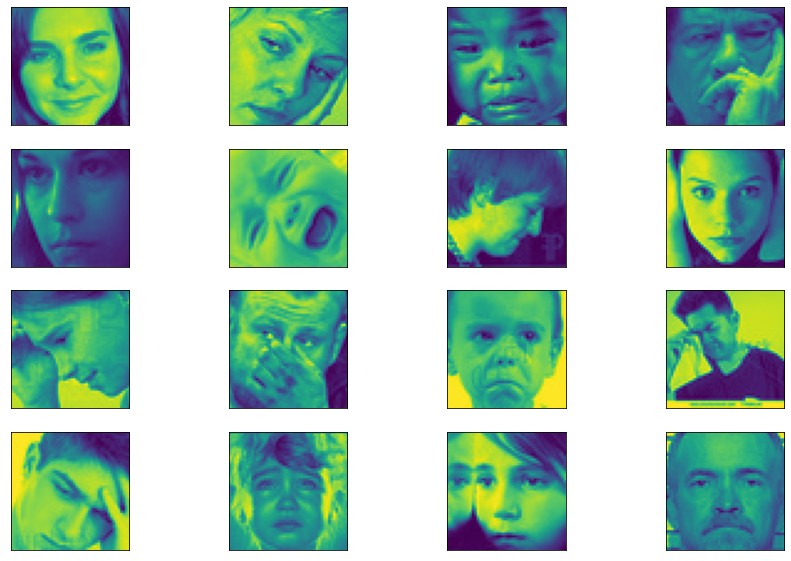

In [6]:
visualize_data('/content/drive/MyDrive/emotion_train/sad')

### Data Preprocessing

In [4]:
image_list = []
label_list = []
Dir = os.listdir(data_path)
for each_folder in Dir:
    for each_image in os.listdir(data_path+'/'+each_folder):
        image_path = data_path+'/'+each_folder+'/'+each_image
        images = cv.imread(image_path)
        image_list.append(images)
        label_list.append(each_folder)
        

In [5]:
pd.value_counts(label_list)

happy    7215
sad      6077
dtype: int64

In [6]:
image_list[0].shape

(48, 48, 3)

In [7]:
print(f'we have {len(image_list)} pic in dataset')

we have 13292 pic in dataset


###  spliting data to train and test


In [8]:
x_train,x_test,y_train,y_test = train_test_split(image_list,label_list,test_size=0.2,random_state=42)

In [9]:
len(x_train)

10633

In [10]:
len(x_test)

2659

### Normalization

In [11]:
x_train = np.array(x_train,dtype=np.float16)/255.0
x_test = np.array(x_test,dtype=np.float16)/255.0

In [42]:
x_test.shape

(2659, 48, 48, 3)

In [43]:
x_train = x_train.reshape( -1, 48,48,3)
y_train = x_test.reshape( -1, 48,48,3)

### label binarizing

In [13]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [45]:
y_test.shape

(2659, 1)

In [14]:
y_train[0:3]

array([[1],
       [1],
       [1]])

In [15]:
print(lb.classes_)

['happy' 'sad']


In [16]:
print(f'we have {len(x_train)}in trainig dataset')
print(f'we have {len(x_test)}in testing dataset')

we have 10633in trainig dataset
we have 2659in testing dataset


In [17]:
early_stopping = callbacks.EarlyStopping(
        patience=10,
        min_delta=0,
        monitor='val_loss',
        restore_best_weights=True,
        verbose=0,
        mode='min', 
        baseline=None,
    )
plateau = callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            patience=4, 
            verbose=0,
            mode='min')

mc = callbacks.ModelCheckpoint('CNN_best_model.h5', monitor='val_loss', mode='min', patience = 10 ,save_best_only=True)

### Build CNN Model

In [19]:
cnn_model = keras.Sequential([

    Conv2D(32,(3,3) ,padding = 'same',activation='relu',input_shape = (48,48,3)),
    Conv2D(64,(3,3) ,padding = 'same',activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    
    
    Conv2D(64,kernel_size=(3,3) ,padding = 'same',activation='relu'),
    MaxPooling2D((2,2)) ,
    Dropout (0.25),

    
    Conv2D(128,kernel_size=(3,3) ,padding = 'same',activation='relu'),
    Dropout(0.25),
    
    Flatten(),
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(2,activation='sigmoid')
])
                    
 
cnn_model.summary()





Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                  

### compile CNN Model

In [24]:
early_stopping = callbacks.EarlyStopping(
        patience=10,
        min_delta=0,
        monitor='val_loss',
        restore_best_weights=True,
        verbose=0,
        mode='min', 
        baseline=None,
    )
plateau = callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            patience=4, 
            verbose=0,
            mode='min')

mc = callbacks.ModelCheckpoint('CNN_best_model.h5', monitor='val_loss', mode='min', patience = 10 ,save_best_only=True)



LEARNING_RATE = 0.0005
cnn_model.compile(
        Adam(learning_rate=LEARNING_RATE),
        loss = 'sparse_categorical_crossentropy',
        metrics = ['acc'])

history_cnn = cnn_model.fit(  x_train , y_train,
                validation_data = (x_test , y_test),
                epochs = 100,
                callbacks = [early_stopping , plateau, mc])



Epoch 1/100
333/333 [==============================] - 12s 12ms/step - loss: 0.6886 - acc: 0.5388 - val_loss: 0.6689 - val_acc: 0.5476 - lr: 5.0000e-04
Epoch 2/100
333/333 [==============================] - 4s 11ms/step - loss: 0.6013 - acc: 0.6718 - val_loss: 0.5245 - val_acc: 0.7458 - lr: 5.0000e-04
Epoch 3/100
333/333 [==============================] - 4s 11ms/step - loss: 0.5102 - acc: 0.7491 - val_loss: 0.4478 - val_acc: 0.7932 - lr: 5.0000e-04
Epoch 4/100
333/333 [==============================] - 4s 11ms/step - loss: 0.4485 - acc: 0.7950 - val_loss: 0.4250 - val_acc: 0.8131 - lr: 5.0000e-04
Epoch 5/100
333/333 [==============================] - 4s 11ms/step - loss: 0.3906 - acc: 0.8263 - val_loss: 0.3522 - val_acc: 0.8349 - lr: 5.0000e-04
Epoch 6/100
333/333 [==============================] - 4s 11ms/step - loss: 0.3487 - acc: 0.8506 - val_loss: 0.3270 - val_acc: 0.8511 - lr: 5.0000e-04
Epoch 7/100
333/333 [==============================] - 4s 11ms/step - loss: 0.3216 - acc: 0.8

In [25]:
cnn_model.evaluate(x_test,y_test)

84/84 [==============================] - 0s 5ms/step - loss: 0.2742 - acc: 0.8804


[0.2741558253765106, 0.8804061412811279]

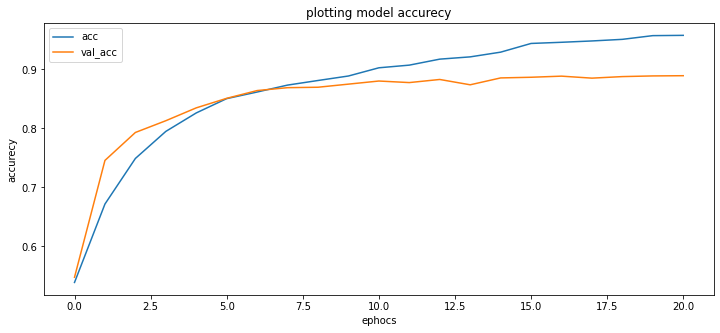

In [27]:
plt.figure(figsize=(12,5))
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])
plt.title('plotting model accurecy')
plt.xlabel('ephocs')
plt.ylabel('accurecy')
plt.legend(['acc','val_acc'])
plt.show()

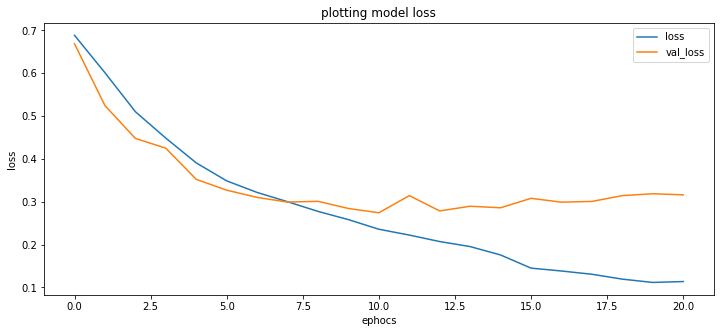

In [30]:
plt.figure(figsize=(12,5))
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('plotting model loss')
plt.xlabel('ephocs')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])
plt.show()

In [74]:
cnn_model.save("emotion_detection.h5")


In [75]:
model=load_model('emotion_detection.h5')

In [44]:
x_pred_cnn = cnn_model.predict(x_test)
print(x_pred_cnn.shape)
print(y_test.shape)

84/84 [==============================] - 0s 4ms/step
(2659, 2)
(2659, 1)


In [68]:
x_pred_label = [np.argmax(i)for i in y_pred_cnn]
x_pred_label[0:5]

[1, 0, 1, 0, 1]

In [50]:
x_train , x_test , y_train , y_test = train_test_split(image_list,label_list,test_size=0.2,random_state=42) 

In [65]:
y_test = np.where(y_test == 'happy', 0, y_test)

y_test = np.where(y_test == 'sad', 1, y_test)
y_test[0:5]

array(['1', '0', '1', '0', '1'], dtype='<U5')

In [69]:
y_test = y_test.astype('int32')

In [70]:
cm = confusion_matrix(labels=y_test, predictions=x_pred_label)
cm

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1277,  179],
       [ 139, 1064]], dtype=int32)>

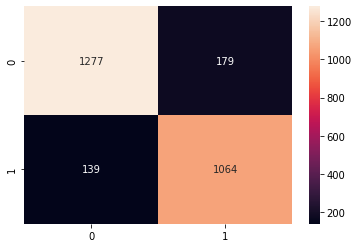

In [73]:
sns.heatmap(cm,annot=True,fmt='d')

In [80]:
print(classification_report(y_test, x_pred_label))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1456
           1       0.86      0.88      0.87      1203

    accuracy                           0.88      2659
   macro avg       0.88      0.88      0.88      2659
weighted avg       0.88      0.88      0.88      2659



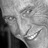

In [81]:
# Plotting image to compare
img = array_to_img(x_test[1])
img

In [85]:
# Finding max value from predition list and comaparing original value vs predicted
labels = lb.classes_
print(labels)
print("Originally : ",labels[np.argmax(y_test[1])])
print("Predicted : ",labels[np.argmax(y_pred_cnn[1])])

['happy' 'sad']
Originally :  happy
Predicted :  happy
